# 문제 정의

- 농구 선수의 경기 기록을 바탕으로 해당 선수들의 포지션을 예측해보자
- 2017년 NBA 농구 선수들의 게임 기록 데이터 셋
- 알고리즘 : 분류(Classification)
- 평가지표 : confusion matrix, precision, recall, F1 score...

## 필수 라이브러리 로딩

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns

# seaborn style
sns.set_theme()

# 경고없애기
import warnings
warnings.filterwarnings(action='ignore') 

# 데이터 수집

- 2017년 NBA 농구 선수의 게임 데이터

In [2]:
df = pd.read_csv('basketball_stat.csv')

## 데이터 탐색

- 가설을 이용한 타당성 검증에 필요한 과정

In [3]:
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   2P      100 non-null    float64
 4   TRB     100 non-null    float64
 5   AST     100 non-null    float64
 6   STL     100 non-null    float64
 7   BLK     100 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.4+ KB


- Player : 선수이름
- Pos : 포지션
- 3P : 한 경기 평균 3점슛 성공 횟수
- 2P : 한 경기 평균 2점슛 성공 횟수
- TRB : 한 경기 평균 리바운드 성공 횟수
- AST : 한 경기 평균 어시스트 성공 횟수
- STL : 한 경기 평균 스틸 성공 횟수
- BLK : 한 경기 평균 블로킹 성공 횟수

In [5]:
df.Pos.value_counts()

SG    50
C     50
Name: Pos, dtype: int64

- C(Center) : 센터, 골대, 포스트 근처에서 슛을 블로킹하고, 리바운드하고, 공을 바깥으로 빼줘서 공격 찬스를 만드는 역할, 골대 근처에서 2점슛으로 득점을 하기도 한다.
- SG(Shooting Guard) : 3점슛등 장거리에서 슛을 해서 점수를 얻는 역할

## 시각화를 통한 데이터 탐색

- 포지션을 예측하는 문제이다.
- 현재 가지고 있는 포지션은 센터와 슈팅가드만 존재한다.
- 불필요하다고 판단되는 특성을 찾아 처리한다.(2P, AST, STL)
- 불필요하다는 근거? 가설 입증이 필요하다

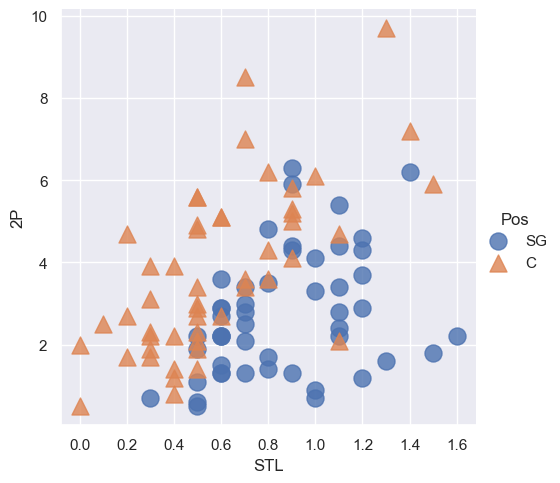

In [8]:
# 스틸, 2점슛 시각화
sns.lmplot(x = 'STL', y = '2P', data = df, fit_reg = False, 
           scatter_kws={'s':150},
          hue = 'Pos',
          markers = ['o', '^'])
plt.show()

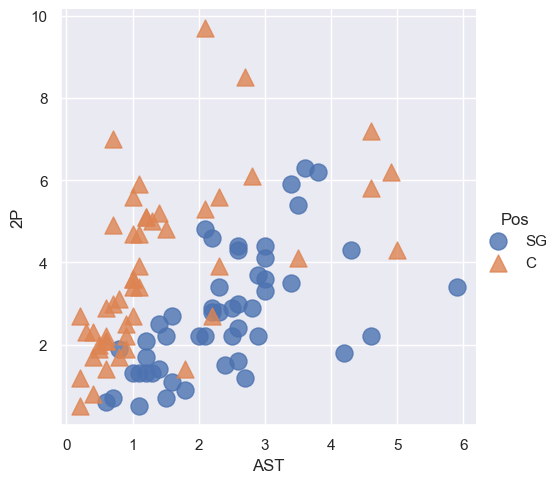

In [9]:
# 어시스트, 2점슛
sns.lmplot(x = 'AST', y = '2P', data = df, fit_reg = False, 
           scatter_kws={'s':150},
          hue = 'Pos',
          markers = ['o', '^'])
plt.show()

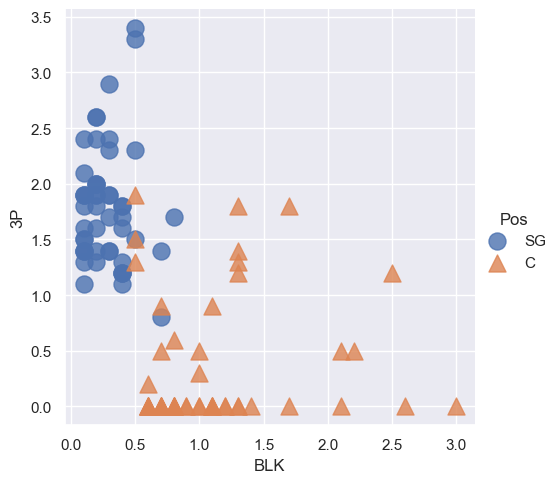

In [10]:
# 블로킹, 3P
sns.lmplot(x = 'BLK', y = '3P', data = df, fit_reg = False, 
           scatter_kws={'s':150},
          hue = 'Pos',
          markers = ['o', '^'])
plt.show()

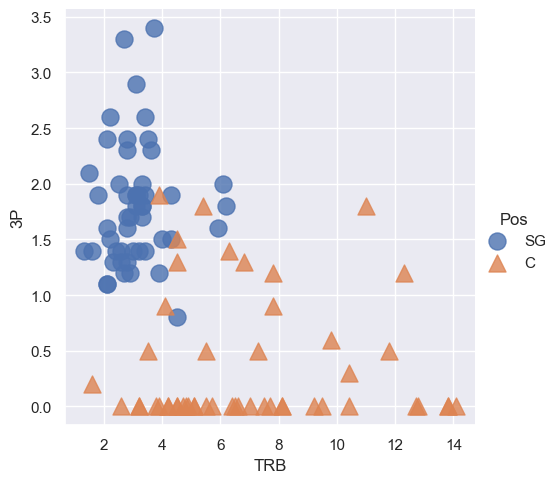

In [11]:
# 리바운드, 3점슛
sns.lmplot(x = 'TRB', y = '3P', data = df, fit_reg = False, 
           scatter_kws={'s':150},
          hue = 'Pos',
          markers = ['o', '^'])
plt.show()

# 데이터 전처리

- 앞선 시각화를 통해 2점슛, 어시스트, 스틸의 특성은 슈팅가드와 센터를 분류하는데 큰 도움이 되지 않는다는 것을 파악했다.
- 불필요하다고 판단한 속성을 제거하고 작업을 수행한다.

In [12]:
df.drop(['2P', 'AST', 'STL'], axis=1, inplace = True)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


In [13]:
x = df[['3P', 'BLK', 'TRB']]
y = df[['Pos']]
x.shape, y.shape

((100, 3), (100, 1))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   TRB     100 non-null    float64
 4   BLK     100 non-null    float64
dtypes: float64(3), object(2)
memory usage: 4.0+ KB


## 훈련세트와 테스트세트 분리

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(80, 3) (20, 3)
(80, 1) (20, 1)


## 최적의 k 찾기

- knn알고리즘에서 조절 가능한 변수는 오직 하나인 이웃의 개수(k)이다.
- k의 개수에 따라 모델의 예측값도 달라진다.
- 따라서 예측값이 가장 높은 최적의 k를 찾는 것이 knn 알고리즘에 중요한 단계이다.

In [28]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(80, 3) (20, 3)
(80, 1) (20, 1)


In [31]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 43 to 44
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pos     80 non-null     object
dtypes: object(1)
memory usage: 1.2+ KB


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 교차검증을 통해 k를 찾는 작업
# k의 범위는 학습 데이터의 절반을 사용
max_range = x_train.shape[0] // 2
#print(max_range)
k_list = []

for i in range(3, max_range, 2):
    k_list.append(i)

print(k_list)

#print(len(k_list))    
# 교차검증값을 저장할 변수
cross_scores = []

for k in k_list[:-2]:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv = 10, scoring='accuracy')
    cross_scores.append(scores.mean())

cross_scores

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


[0.9125,
 0.9125,
 0.9375,
 0.9375,
 0.9375,
 0.925,
 0.925,
 0.9375,
 0.9125,
 0.925,
 0.9125,
 0.8875,
 0.9,
 0.875,
 0.8625,
 0.85,
 0.8375]

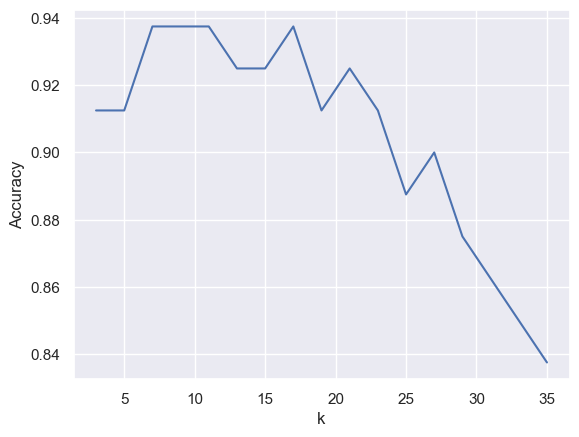

In [43]:
plt.plot(k_list[:-2], cross_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [44]:
k = k_list[cross_scores.index(max(cross_scores))]
k

7

# 데이터 모델링

In [45]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(x_train, y_train.values.ravel())

pred = knn.predict(x_test)

In [46]:
comparison = pd.DataFrame({'prediction':pred, 'Actual':y_test.values.ravel()})
comparison

,prediction,Actual
0,SG,SG
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,C
9,C,C


In [48]:
from sklearn.metrics import accuracy_score
print('Accuracy : ', accuracy_score(y_test.values.ravel(), pred))

Accuracy :  0.85
